In [1]:
# %matplotlib widget

import os
from copy import deepcopy as copy
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from astropy.stats import biweight_location, biweight_midvariance

from lvmdrp import path, __version__ as drpver
from lvmdrp.utils import metadata as md
from lvmdrp.core.constants import SPEC_CHANNELS
from lvmdrp.core.fiberrows import FiberRows
from lvmdrp.core.spectrum1d import Spectrum1D
from lvmdrp.core.rss import RSS
from lvmdrp.functions import run_drp as drp
from lvmdrp.functions import run_quickdrp as qdrp

from lvmdrp.functions import imageMethod, rssMethod


ORIG_MASTER_DIR = os.getenv("LVM_MASTER_DIR")
MASTER_CON_LAMPS = {"b": "ldls", "r": "ldls", "z": "quartz"}
# MASTER_ARC_LAMPS = {"b": "hgne", "r": "neon", "z": "neon"}
MASTER_ARC_LAMPS = {"b": "neon_hgne_argon_xenon", "r": "neon_hgne_argon_xenon", "z": "neon_hgne_argon_xenon"}
SLITMAP = Table(drp.fibermap.data)


def fit_continuum(spec, median_box=30, thresh=1.2, niter=5, poly_deg=10, wave_range=None, wave_masks=None, reset_mask=True):
    
    # mask bad pixels
    # spec._data[spec._mask] = np.nan
    spec._mask[:] = False

    # mask wavelength regions
    if wave_range is not None:
        iwave, fwave = wave_range
        spec._mask = ~((iwave <= spec._wave) & (spec._wave <= fwave))
        spec._data[spec._mask] = np.nan
    
    # mask wavelength regions
    if wave_masks is not None:
        for iwave, fwave in wave_masks:
            spec._mask |= (iwave <= spec._wave) & (spec._wave <= fwave)
            spec._data[spec._mask] = np.nan

    # copy original spectrum object
    spec_s = copy(spec)

    # replace bad pixels with NaNs
    spec_s._data[spec_s._mask] = np.nan
    spec_s._data = median_filter(spec_s._data, size=median_box)

    for i in range(niter):
        mask = np.divide(spec._data, spec_s._data, where=spec_s._data != 0, out=np.zeros_like(spec_s._data)) > thresh

        spec_s = Spectrum1D(data=np.interp(spec._pixels, spec._pixels[mask], spec._data[mask]))
        spec_s._data = median_filter(spec_s._data, median_box)


    # define continuum with last iteration's mask
    mask = np.divide(spec._data, spec_s._data, where=spec_s._data != 0, out=np.zeros_like(spec_s._data)) > thresh
    
    # create continuum spectrum and update mask
    out_con = copy(spec)
    out_con._mask |= ~mask

    # fit polynomial function
    coeffs = out_con.smoothSpec(size=poly_deg, method="BSpline")
    # coeffs = out_con.smoothPoly(deg=poly_deg)

    # reset mask
    if reset_mask:
        out_con._mask[:] = False
    
    return coeffs, out_con

In [2]:
MJD = 60264
frames_table = md.get_metadata(tileid="*", mjd=MJD)
frames_table.query("imagetyp == 'bias' | imagetyp == 'dark' | imagetyp == 'flat' | imagetyp == 'arc'", inplace=True)

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028055/60264/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028007/60264/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1027986/60264/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1111/60264/raw_metadata.hdf5
[INFO]: found 7 frames in store '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028055/60264/raw_metadata.hdf5'
[INFO]: number of frames after filtering 7
[INFO]: found 63 frames in store '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028007/60264/raw_metadata.hdf5'
[INFO]: number of frames after filtering 63
[INFO]: found 26 frames in store '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/l

In [3]:
masters_mjd = qdrp.get_master_mjd(MJD)
masters_path = os.path.join(ORIG_MASTER_DIR, f"{masters_mjd}")
print(masters_path)

/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/sandbox/calib/60255


In [4]:
expnums = list(range(7832, 7832+12))

flats_table = frames_table.query("expnum in @expnums")
flats_table = flats_table.sort_values(["camera", "expnum"])

In [5]:
# twilight_windows = {
#     "b": [(3600, 3680), (3763, 3770), (3840, 3880), (3940, 3960), (3990, 4025), (4111, 4160),
#           (4180, 4210), (4400, 4500), (4540, 4575), (4720, 4850), (4900, 5150), (5240, 5500), (5620, 5780)],
#     "r": [(5860, 5880), (6020, 6155), (6400, 6455), (6660, 6800), (7060, 7225), (7375, 7385), (7445, 7460), (7500, 7520)],
#     "z": [(7450, 7550), (7728, 7745), (7762, 7770), (7797, 7805), (7813, 7819), (7825, 7839), (7892, 7908), (7935, 7943),
#           (7995, 8009), (8033, 8047), (8065, 8075), (8109, 8135), (8150, 8215), (8245, 8269), (8320, 8335),
#           (8435, 8448), (8570, 8610), (8700, 8745), (9056, 9086), (9110, 9144), (9180, 9210),
#           (9570, 9584), (9635, 9663), (9762, 9781)]
# }

mask_bands = {
    "b": [(3914, 4000), (4263, 4327)],
    "r": [(5825, 5915), (6260, 6300), (6530, 6620), (6790, 6990), (7580, 7750)],
    "z": [(7580, 7750), (8200, 8250), (8320, 8350)]
}

flat_analogs = flats_table.groupby(["camera"])
lamp = "twilight"


In [6]:
mflat_paths = []
for camera in flat_analogs.groups:
    flats = flat_analogs.get_group(camera)
    flat = flats.iloc[0].to_dict()

    print(flats.sort_values("expnum").to_string())

    arc_lamp = MASTER_ARC_LAMPS[camera[0]]
    
    # define master paths for target frames
    mpixmask_path = os.path.join(masters_path, f"lvm-mpixmask-{camera}.fits")
    mbias_path = os.path.join(masters_path, f"lvm-mbias-{camera}.fits")
    mdark_path = os.path.join(masters_path, f"lvm-mdark-{camera}.fits")
    mpixflat_path = os.path.join(masters_path, f"lvm-mpixflat-{camera}.fits")
    mtrace_path = os.path.join(masters_path, f"lvm-mtrace-{camera}.fits")
    mwidth_path = os.path.join(masters_path, f"lvm-mwidth-{camera}.fits")
    mwave_path = os.path.join(masters_path, f"lvm-mwave_{arc_lamp}-{camera}.fits")
    mlsf_path = os.path.join(masters_path, f"lvm-mlsf_{arc_lamp}-{camera}.fits")
    
    # define master frame path
    mflat_path = path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"mflat_{lamp}", camera=camera)
    mflat_paths.append(mflat_path)
    os.makedirs(os.path.dirname(mflat_path), exist_ok=True)
    
    # reduce individual exposures
    rsss = []
    for flat in flats.to_dict("records"):
        flat_path = path.full("lvm_raw", camspec=flat["camera"], **flat)
        pflat_path = path.full("lvm_anc", drpver=drpver, kind="p", imagetype=flat["imagetyp"], **flat)
        dflat_path = path.full("lvm_anc", drpver=drpver, kind="d", imagetype=flat["imagetyp"], **flat)
        xflat_path = path.full("lvm_anc", drpver=drpver, kind="x", imagetype=flat["imagetyp"], **flat)
        wflat_path = path.full("lvm_anc", drpver=drpver, kind="w", imagetype=flat["imagetyp"], **flat)
        hflat_path = path.full("lvm_anc", drpver=drpver, kind="h", imagetype=flat["imagetyp"], **flat)
        os.makedirs(os.path.dirname(xflat_path), exist_ok=True)

        # detrend frames
        if os.path.isfile(dflat_path):
            print(f"skipping {dflat_path}, file already exist")
        else:
            imageMethod.preproc_raw_frame(in_image=flat_path, out_image=pflat_path, in_mask=mpixmask_path)
            imageMethod.detrend_frame(in_image=pflat_path, out_image=dflat_path, in_bias=mbias_path, in_dark=mdark_path, in_pixelflat=mpixflat_path, in_slitmap=SLITMAP)

        # extract 1D spectra
        if os.path.isfile(xflat_path):
            print(f"skipping {xflat_path}, file already exist")
        else:
            imageMethod.extract_spectra(in_image=dflat_path, out_rss=xflat_path, in_trace=mtrace_path, in_fwhm=mwidth_path, method="optimal", parallel=10)

        # add wavelength solution
        rssMethod.create_pixel_table(in_rss=xflat_path, out_rss=wflat_path, arc_wave=mwave_path, arc_fwhm=mlsf_path)

        # wavelength resampling
        iwave, fwave = SPEC_CHANNELS[camera[0]]
        if os.path.isfile(hflat_path):
            print(f"skipping {hflat_path}, file already exist")
        else:
            rssMethod.resample_wavelength(in_rss=wflat_path, out_rss=hflat_path, disp_pix=0.5, start_wave=iwave, end_wave=fwave, err_sim=5, parallel=0, extrapolate=False)

        # calculate normalized continuum
        rss = rssMethod.loadRSS(hflat_path)
        median_fiber = np.nanmedian(rss._data, axis=0)
        median_fiber = Spectrum1D(data=median_fiber, wave=rss._wave, mask=np.prod(rss._mask, axis=0).astype(bool))
        _, median_fiber = fit_continuum(median_fiber, thresh=1.0001, niter=1, median_box=50, poly_deg=4, wave_range=(iwave,fwave), wave_masks=mask_bands[camera[0]])

        # normalize spectra per exposure to the median fiber
        rss._data = rss._data / median_fiber._data
        rss._error = rss._error / median_fiber._data
        rsss.append(rss)
        
    # combine RSS exposures using an average
    mrss = RSS(data=np.zeros_like(rsss[0]._data), error=np.zeros_like(rsss[0]._error), mask=np.ones_like(rsss[0]._mask, dtype=bool),
               header=copy(rsss[0]._header), slitmap=copy(rsss[0]._slitmap))
    # select non-std fibers
    fibermap =  mrss._slitmap[mrss._slitmap["spectrographid"] == int(camera[1])]
    select_allstd = fibermap["telescope"] == "Spec"
    select_nonstd = ~select_allstd
    for i, rss in enumerate(rsss):
        # coadding all non-std fibers
        mrss._data[select_nonstd] = mrss._data[select_nonstd] + rss._data[select_nonstd]
        mrss._error[select_nonstd] = np.sqrt(mrss._error[select_nonstd]**2 + rss._error[select_nonstd]**2)
        mrss._mask[select_nonstd] = mrss._mask[select_nonstd] & rss._mask[select_nonstd]
        
        # put std fibers in the right position
        fiber_id = f"P1-{i+1}"
        idx = np.where(fibermap["orig_ifulabel"].value == fiber_id)
        mrss._data[idx] = rss._data[idx]
        mrss._error[idx] = rss._error[idx]
        mrss._mask[idx] = mrss._mask[idx] & rss._mask[idx]
        mrss._header.update(rss._header["STD*"])
    
    # compute average of non-std fibers
    mrss._data[select_nonstd] = mrss._data[select_nonstd] / len(rsss)
    mrss._error[select_nonstd] = mrss._error[select_nonstd] / np.sqrt(len(rsss))

    # mask invalid pixels
    mrss._mask |= np.isnan(mrss._data) | (mrss._data <= 0)

    mrss.writeFitsData(mflat_path)

[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b1-00007832.fits


    hemi  tileid    mjd   rmjd imagetyp spec camera  expnum  exptime   neon   hgne  krypton  xenon  argon   ldls  quartz    quality  qual  stage  status  drpqual                    name
174    s    1111  60264  60264     flat  sp1     b1    7832    181.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-b1-00007832.fits
702    s    1111  60264  60264     flat  sp1     b1    7833     57.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-b1-00007833.fits
608    s    1111  60264  60264     flat  sp1     b1    7834     29.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-b1-00007834.fits
710    s    1111  60264  60264     flat  sp1     b1    7835     18.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-b1-00007835.fits
681    s    1111  60264  60264     flat  sp1     b1    7836     12.0  

[INFO]: writing extracted spectra to lvm-xflat-b1-00007832.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b1-00007832.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b1-00007833.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b1-00007833.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b1-00007833.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b1-00007833.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b1-00007834.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b1-00007834.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b1-00007834.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b1-00007834.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b1-00007835.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b1-00007835.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b1-00007835.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b1-00007835.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b1-00007836.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b1-00007836.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b1-00007836.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b1-00007836.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b1-00007837.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b1-00007837.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b1-00007837.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b1-00007837.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b1-00007838.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b1-00007838.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b1-00007838.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b1-00007838.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b1-00007839.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b1-00007839.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b1-00007839.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b1-00007839.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b1-00007840.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b1-00007840.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b1-00007840.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b1-00007840.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b1-00007841.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b1-00007841.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b1-00007841.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b1-00007841.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b1-00007842.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b1-00007842.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b1-00007842.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b1-00007842.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b1-00007843.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b1-00007843.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b1-00007843.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b1-00007843.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b2-00007832.fits


    hemi  tileid    mjd   rmjd imagetyp spec camera  expnum  exptime   neon   hgne  krypton  xenon  argon   ldls  quartz    quality  qual  stage  status  drpqual                    name
672    s    1111  60264  60264     flat  sp2     b2    7832    181.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-b2-00007832.fits
660    s    1111  60264  60264     flat  sp2     b2    7833     57.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-b2-00007833.fits
670    s    1111  60264  60264     flat  sp2     b2    7834     29.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-b2-00007834.fits
382    s    1111  60264  60264     flat  sp2     b2    7835     18.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-b2-00007835.fits
413    s    1111  60264  60264     flat  sp2     b2    7836     12.0  

[INFO]: writing extracted spectra to lvm-xflat-b2-00007832.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b2-00007832.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b2-00007833.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b2-00007833.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b2-00007833.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b2-00007833.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b2-00007834.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b2-00007834.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b2-00007834.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b2-00007834.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b2-00007835.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b2-00007835.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b2-00007835.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b2-00007835.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b2-00007836.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b2-00007836.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b2-00007836.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b2-00007836.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b2-00007837.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b2-00007837.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b2-00007837.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b2-00007837.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b2-00007838.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b2-00007838.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b2-00007838.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b2-00007838.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b2-00007839.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b2-00007839.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b2-00007839.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b2-00007839.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b2-00007840.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b2-00007840.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b2-00007840.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b2-00007840.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b2-00007841.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b2-00007841.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b2-00007841.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b2-00007841.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b2-00007842.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b2-00007842.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b2-00007842.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b2-00007842.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b2-00007843.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b2-00007843.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b2-00007843.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b2-00007843.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b3-00007832.fits


    hemi  tileid    mjd   rmjd imagetyp spec camera  expnum  exptime   neon   hgne  krypton  xenon  argon   ldls  quartz    quality  qual  stage  status  drpqual                    name
334    s    1111  60264  60264     flat  sp3     b3    7832    181.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-b3-00007832.fits
168    s    1111  60264  60264     flat  sp3     b3    7833     57.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-b3-00007833.fits
606    s    1111  60264  60264     flat  sp3     b3    7834     29.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-b3-00007834.fits
453    s    1111  60264  60264     flat  sp3     b3    7835     18.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-b3-00007835.fits
598    s    1111  60264  60264     flat  sp3     b3    7836     12.0  

[INFO]: writing extracted spectra to lvm-xflat-b3-00007832.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b3-00007832.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b3-00007833.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b3-00007833.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b3-00007833.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b3-00007833.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b3-00007834.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b3-00007834.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b3-00007834.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b3-00007834.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b3-00007835.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b3-00007835.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b3-00007835.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b3-00007835.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b3-00007836.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b3-00007836.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b3-00007836.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b3-00007836.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b3-00007837.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b3-00007837.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b3-00007837.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b3-00007837.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b3-00007838.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b3-00007838.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b3-00007838.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b3-00007838.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b3-00007839.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b3-00007839.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b3-00007839.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b3-00007839.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b3-00007840.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b3-00007840.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b3-00007840.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b3-00007840.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b3-00007841.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b3-00007841.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b3-00007841.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b3-00007841.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b3-00007842.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b3-00007842.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b3-00007842.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b3-00007842.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-b3-00007843.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-b3-00007843.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-b3-00007843.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-b3-00007843.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r1-00007832.fits


    hemi  tileid    mjd   rmjd imagetyp spec camera  expnum  exptime   neon   hgne  krypton  xenon  argon   ldls  quartz    quality  qual  stage  status  drpqual                    name
238    s    1111  60264  60264     flat  sp1     r1    7832    181.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-r1-00007832.fits
754    s    1111  60264  60264     flat  sp1     r1    7833     57.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-r1-00007833.fits
210    s    1111  60264  60264     flat  sp1     r1    7834     29.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-r1-00007834.fits
768    s    1111  60264  60264     flat  sp1     r1    7835     18.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-r1-00007835.fits
199    s    1111  60264  60264     flat  sp1     r1    7836     12.0  

[INFO]: writing extracted spectra to lvm-xflat-r1-00007832.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r1-00007832.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r1-00007833.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r1-00007833.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r1-00007833.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r1-00007833.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r1-00007834.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r1-00007834.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r1-00007834.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r1-00007834.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r1-00007835.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r1-00007835.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r1-00007835.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r1-00007835.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r1-00007836.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r1-00007836.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r1-00007836.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r1-00007836.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r1-00007837.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r1-00007837.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r1-00007837.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r1-00007837.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r1-00007838.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r1-00007838.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r1-00007838.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r1-00007838.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r1-00007839.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r1-00007839.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r1-00007839.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r1-00007839.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r1-00007840.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r1-00007840.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r1-00007840.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r1-00007840.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r1-00007841.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r1-00007841.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r1-00007841.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r1-00007841.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r1-00007842.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r1-00007842.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r1-00007842.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r1-00007842.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r1-00007843.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r1-00007843.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r1-00007843.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r1-00007843.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r2-00007832.fits


    hemi  tileid    mjd   rmjd imagetyp spec camera  expnum  exptime   neon   hgne  krypton  xenon  argon   ldls  quartz    quality  qual  stage  status  drpqual                    name
770    s    1111  60264  60264     flat  sp2     r2    7832    181.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-r2-00007832.fits
742    s    1111  60264  60264     flat  sp2     r2    7833     57.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-r2-00007833.fits
630    s    1111  60264  60264     flat  sp2     r2    7834     29.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-r2-00007834.fits
155    s    1111  60264  60264     flat  sp2     r2    7835     18.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-r2-00007835.fits
654    s    1111  60264  60264     flat  sp2     r2    7836     12.0  

[INFO]: writing extracted spectra to lvm-xflat-r2-00007832.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r2-00007832.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r2-00007833.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r2-00007833.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r2-00007833.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r2-00007833.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r2-00007834.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r2-00007834.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r2-00007834.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r2-00007834.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r2-00007835.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r2-00007835.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r2-00007835.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r2-00007835.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r2-00007836.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r2-00007836.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r2-00007836.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r2-00007836.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r2-00007837.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r2-00007837.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r2-00007837.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r2-00007837.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r2-00007838.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r2-00007838.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r2-00007838.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r2-00007838.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r2-00007839.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r2-00007839.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r2-00007839.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r2-00007839.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r2-00007840.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r2-00007840.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r2-00007840.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r2-00007840.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r2-00007841.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r2-00007841.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r2-00007841.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r2-00007841.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r2-00007842.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r2-00007842.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r2-00007842.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r2-00007842.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r2-00007843.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r2-00007843.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r2-00007843.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r2-00007843.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r3-00007832.fits


    hemi  tileid    mjd   rmjd imagetyp spec camera  expnum  exptime   neon   hgne  krypton  xenon  argon   ldls  quartz    quality  qual  stage  status  drpqual                    name
834    s    1111  60264  60264     flat  sp3     r3    7832    181.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-r3-00007832.fits
449    s    1111  60264  60264     flat  sp3     r3    7833     57.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-r3-00007833.fits
707    s    1111  60264  60264     flat  sp3     r3    7834     29.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-r3-00007834.fits
594    s    1111  60264  60264     flat  sp3     r3    7835     18.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-r3-00007835.fits
108    s    1111  60264  60264     flat  sp3     r3    7836     12.0  

[INFO]: writing extracted spectra to lvm-xflat-r3-00007832.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r3-00007832.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r3-00007833.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r3-00007833.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r3-00007833.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r3-00007833.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r3-00007834.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r3-00007834.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r3-00007834.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r3-00007834.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r3-00007835.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r3-00007835.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r3-00007835.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r3-00007835.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r3-00007836.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r3-00007836.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r3-00007836.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r3-00007836.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r3-00007837.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r3-00007837.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r3-00007837.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r3-00007837.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r3-00007838.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r3-00007838.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r3-00007838.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r3-00007838.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r3-00007839.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r3-00007839.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r3-00007839.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r3-00007839.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r3-00007840.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r3-00007840.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r3-00007840.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r3-00007840.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r3-00007841.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r3-00007841.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r3-00007841.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r3-00007841.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r3-00007842.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r3-00007842.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r3-00007842.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r3-00007842.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-r3-00007843.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-r3-00007843.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-r3-00007843.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-r3-00007843.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z1-00007832.fits


    hemi  tileid    mjd   rmjd imagetyp spec camera  expnum  exptime   neon   hgne  krypton  xenon  argon   ldls  quartz    quality  qual  stage  status  drpqual                    name
550    s    1111  60264  60264     flat  sp1     z1    7832    181.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-z1-00007832.fits
579    s    1111  60264  60264     flat  sp1     z1    7833     57.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-z1-00007833.fits
200    s    1111  60264  60264     flat  sp1     z1    7834     29.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-z1-00007834.fits
326    s    1111  60264  60264     flat  sp1     z1    7835     18.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-z1-00007835.fits
692    s    1111  60264  60264     flat  sp1     z1    7836     12.0  

[INFO]: writing extracted spectra to lvm-xflat-z1-00007832.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z1-00007832.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z1-00007833.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z1-00007833.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z1-00007833.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z1-00007833.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z1-00007834.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z1-00007834.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z1-00007834.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z1-00007834.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z1-00007835.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z1-00007835.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z1-00007835.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z1-00007835.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z1-00007836.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z1-00007836.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z1-00007836.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z1-00007836.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z1-00007837.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z1-00007837.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z1-00007837.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z1-00007837.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z1-00007838.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z1-00007838.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z1-00007838.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z1-00007838.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z1-00007839.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z1-00007839.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z1-00007839.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z1-00007839.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z1-00007840.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z1-00007840.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z1-00007840.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z1-00007840.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z1-00007841.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z1-00007841.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z1-00007841.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z1-00007841.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z1-00007842.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z1-00007842.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z1-00007842.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z1-00007842.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z1-00007843.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z1-00007843.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z1-00007843.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z1-00007843.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z2-00007832.fits


    hemi  tileid    mjd   rmjd imagetyp spec camera  expnum  exptime   neon   hgne  krypton  xenon  argon   ldls  quartz    quality  qual  stage  status  drpqual                    name
719    s    1111  60264  60264     flat  sp2     z2    7832    181.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-z2-00007832.fits
253    s    1111  60264  60264     flat  sp2     z2    7833     57.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-z2-00007833.fits
278    s    1111  60264  60264     flat  sp2     z2    7834     29.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-z2-00007834.fits
547    s    1111  60264  60264     flat  sp2     z2    7835     18.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-z2-00007835.fits
396    s    1111  60264  60264     flat  sp2     z2    7836     12.0  

[INFO]: writing extracted spectra to lvm-xflat-z2-00007832.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z2-00007832.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z2-00007833.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z2-00007833.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z2-00007833.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z2-00007833.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z2-00007834.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z2-00007834.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z2-00007834.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z2-00007834.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z2-00007835.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z2-00007835.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z2-00007835.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z2-00007835.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z2-00007836.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z2-00007836.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z2-00007836.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z2-00007836.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z2-00007837.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z2-00007837.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z2-00007837.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z2-00007837.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z2-00007838.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z2-00007838.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z2-00007838.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z2-00007838.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z2-00007839.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z2-00007839.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z2-00007839.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z2-00007839.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z2-00007840.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z2-00007840.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z2-00007840.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z2-00007840.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z2-00007841.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z2-00007841.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z2-00007841.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z2-00007841.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z2-00007842.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z2-00007842.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z2-00007842.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z2-00007842.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z2-00007843.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z2-00007843.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z2-00007843.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z2-00007843.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z3-00007832.fits


    hemi  tileid    mjd   rmjd imagetyp spec camera  expnum  exptime   neon   hgne  krypton  xenon  argon   ldls  quartz    quality  qual  stage  status  drpqual                    name
331    s    1111  60264  60264     flat  sp3     z3    7832    181.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-z3-00007832.fits
322    s    1111  60264  60264     flat  sp3     z3    7833     57.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-z3-00007833.fits
822    s    1111  60264  60264     flat  sp3     z3    7834     29.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-z3-00007834.fits
558    s    1111  60264  60264     flat  sp3     z3    7835     18.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-z3-00007835.fits
234    s    1111  60264  60264     flat  sp3     z3    7836     12.0  

[INFO]: writing extracted spectra to lvm-xflat-z3-00007832.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z3-00007832.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z3-00007833.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z3-00007833.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z3-00007833.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z3-00007833.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z3-00007834.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z3-00007834.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z3-00007834.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z3-00007834.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z3-00007835.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z3-00007835.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z3-00007835.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z3-00007835.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z3-00007836.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z3-00007836.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z3-00007836.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z3-00007836.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z3-00007837.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z3-00007837.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z3-00007837.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z3-00007837.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z3-00007838.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z3-00007838.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z3-00007838.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z3-00007838.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z3-00007839.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z3-00007839.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z3-00007839.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z3-00007839.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z3-00007840.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z3-00007840.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z3-00007840.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z3-00007840.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z3-00007841.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z3-00007841.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z3-00007841.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z3-00007841.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z3-00007842.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z3-00007842.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z3-00007842.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z3-00007842.fits, file already exist


[INFO]: extracting fiber spectra using fiber profile fitting from lvm-dflat-z3-00007843.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-dflat-z3-00007843.fits, file already exist


[INFO]: writing extracted spectra to lvm-xflat-z3-00007843.fits


skipping /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0001XX/1111/60264/ancillary/lvm-hflat-z3-00007843.fits, file already exist


(0.0, 2.5)

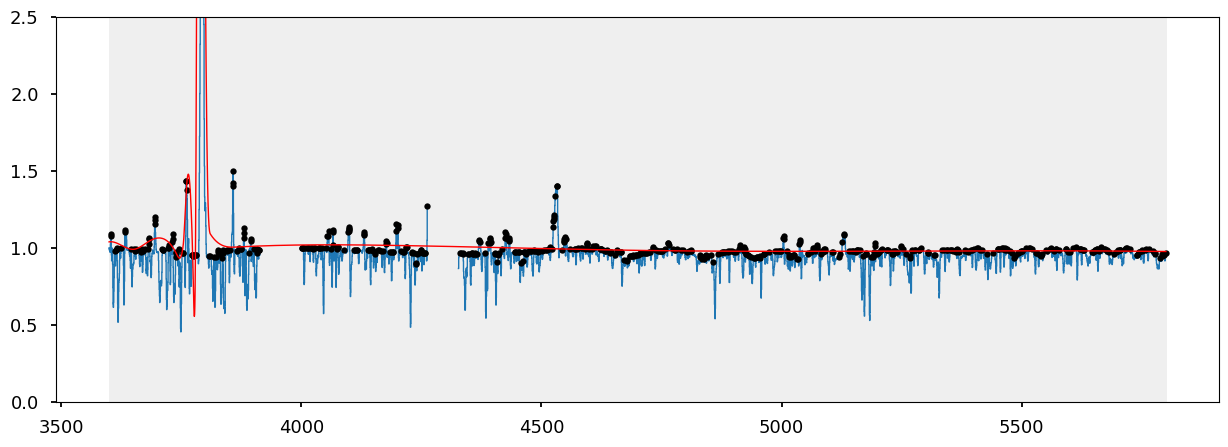

In [12]:

camera = "b1"
expnum = 7832

mflat_path = path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"mflat_{lamp}", camera=camera)

xflat = RSS()
xflat.loadFitsData(mflat_path)

idx = 600
plt.figure(figsize=(15, 5))
iwave, fwave = SPEC_CHANNELS[camera[0]]
plt.axvspan(iwave, fwave, color="0.7", alpha=0.2)

coeffs, cont = fit_continuum(xflat[idx], thresh=1.0001, niter=1, median_box=10, poly_deg=3, wave_range=(iwave,fwave), wave_masks=mask_bands[camera[0]], reset_mask=False)

plt.step(xflat[idx]._wave, xflat[idx]._data, where="mid", lw=1)
plt.plot(xflat[idx]._wave[~cont._mask], xflat[idx]._data[~cont._mask], ".k")
plt.plot(cont._wave, cont._data, "-r", lw=1)
plt.ylim(0, 2.5)

In [13]:

def create_twilight_flat(in_rsss, out_rsss, in_waves=None, median_box=50, wave_range=None, wave_masks=None, clip_sigma=None, thresh=1.0001, niter=1, poly_deg=10, display_plots=True):

    # stack twilight flats
    rss = RSS()
    rss.loadFitsData(in_rsss[0])
    rsss = [rssMethod.loadRSS(in_rss) for in_rss in in_rsss]
    flat = rss.stackRSS(rsss, axis=1)

    # copy original twilight flat
    orig_flat = copy(flat)

    # useful metadata
    camera = rss._header["CCD"]
    unit = rss._header["BUNIT"]

    # update mask for invalid values
    flat._mask |= np.isnan(flat._data) | np.isinf(flat._data)

    # interpolate bad pixels in each fiber
    flat.interpolate_data(axis="X", reset_mask=False)

    # remove high-frequency features and update mask
    if median_box is not None:
        flat._data = median_filter(flat._data, (1, median_box))
        flat._mask |= np.isnan(flat._data)

    # sigma clipping
    if clip_sigma is not None:
        if isinstance(clip_sigma, (int, float)):
            low, high = clip_sigma, clip_sigma
        elif isinstance(clip_sigma, (list, tuple)) and len(clip_sigma) == 2:
            low, high = clip_sigma
        else:
            raise ValueError("clip_sigma must be a number or a list/tuple of two numbers")
        
        ave = biweight_location(flat._data, axis=1, ignore_nan=True)
        std = biweight_midvariance(flat._data, axis=1, ignore_nan=True)
        mask = ~flat._mask | (np.abs(flat._data - ave[:, None]) < low * std[:, None]) | (np.abs(flat._data - ave[:, None]) > high * std[:, None])
        flat._data[~mask] = np.nan
        flat._mask[~mask] = True
        flat.interpolate_data(axis="X", reset_mask=False)

    # mask bad fibers
    fibermap = flat._slitmap
    select_bad = fibermap["fibstatus"] == 1
    flat._mask[select_bad] = True
    flat._data[select_bad] = np.nan

    # fit continuum above absorption features
    flat._coeffs = np.zeros((flat._fibers, poly_deg+1))
    for ifiber in range(flat._fibers):
        flat_spec = flat[ifiber]
        # skip if all pixels are masked
        if flat_spec._mask.all():
            continue
        # fit continuum
        coeffs, cont_spec = fit_continuum(flat_spec, thresh=thresh, niter=niter, median_box=median_box, poly_deg=poly_deg, wave_range=wave_range, wave_masks=wave_masks)
        cont_spec._mask[:] = False
        # update flatfielded spectrum
        flat[ifiber] = cont_spec
        # update coefficients
        flat._coeffs[ifiber] = coeffs
    
    # interpolate bad fibers
    flat.interpolate_coeffs()

    # plot flatfielded twilight flat
    if display_plots:
        fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True, sharey=True)
        plt.ylim(0, 1.5)
        axes[0].set_title(f"Twilight flat for channel = {camera[0]}", loc="left")
        for window in wave_masks:
            axes[0].axvspan(*window, color="k", alpha=0.5)
            axes[1].axvspan(*window, color="k", alpha=0.5)
            axes[2].axvspan(*window, color="k", alpha=0.5)
        if wave_range is not None:
            axes[0].axvline(wave_range[0], color="k", ls="--", lw=1)
            axes[0].axvline(wave_range[1], color="k", ls="--", lw=1)
            axes[1].axvline(wave_range[0], color="k", ls="--", lw=1)
            axes[1].axvline(wave_range[1], color="k", ls="--", lw=1)
            axes[2].axvline(wave_range[0], color="k", ls="--", lw=1)
            axes[2].axvline(wave_range[1], color="k", ls="--", lw=1)

        # color by fiber status
        # dead_fibers = fibermap["fibstatus"] == 1
        # weak_fibers = fibermap["fibstatus"] == 2
        # good_fibers = fibermap["fibstatus"] == 0
        dead_fibers = fibermap["spectrographid"] == 1
        weak_fibers = fibermap["spectrographid"] == 2
        good_fibers = fibermap["spectrographid"] == 3
        axes[0].step(orig_flat._wave[dead_fibers].T, orig_flat._data[dead_fibers].T, lw=1, color="0.2", alpha=0.1)
        axes[0].step(orig_flat._wave[weak_fibers].T, orig_flat._data[weak_fibers].T, lw=1, color="tab:orange", alpha=0.1)
        axes[0].step(orig_flat._wave[good_fibers].T, orig_flat._data[good_fibers].T, lw=1, color="tab:blue", alpha=0.1)
        axes[1].plot(flat._wave[dead_fibers].T, flat._data[dead_fibers].T, lw=1, color="0.2", alpha=0.1)
        axes[1].plot(flat._wave[weak_fibers].T, flat._data[weak_fibers].T, lw=1, color="tab:orange", alpha=0.1)
        axes[1].plot(flat._wave[good_fibers].T, flat._data[good_fibers].T, lw=1, color="tab:blue", alpha=0.1)
        axes[2].step(orig_flat._wave[dead_fibers].T, (orig_flat._data / flat._data)[dead_fibers].T, lw=1, color="0.2", alpha=0.1)
        axes[2].step(orig_flat._wave[weak_fibers].T, (orig_flat._data / flat._data)[weak_fibers].T, lw=1, color="tab:orange", alpha=0.1)
        axes[2].step(orig_flat._wave[good_fibers].T, (orig_flat._data / flat._data)[good_fibers].T, lw=1, color="tab:blue", alpha=0.1)
        axes[2].set_xlabel("Wavelength (Angstrom)")
        axes[0].set_ylabel(f"Counts ({unit})")
        axes[1].set_ylabel("Relative counts")
        axes[2].set_ylabel(f"Counts ({unit})")
        plt.show()

    # split RSS into individual spectrographs
    for i, new_flat in enumerate(flat.splitRSS(axis=1, parts=len(in_rsss))):
        # resample back to the native wavelength grid
        if in_waves is not None:
            waves = FiberRows()
            waves.loadFitsData(in_waves[i])

            new_flats = []
            for ifiber in range(new_flat._fibers):
                new_flats.append(new_flat[ifiber].resampleSpec(waves[ifiber]._data[:-1], method="linear", err_sim=5))
            new_flat = RSS.from_spectra1d(new_flats)

        # update header and slitmap
        new_flat._header = rsss[i]._header
        new_flat._slitmap = rsss[i]._slitmap
        new_flat._good_fibers = rsss[i]._good_fibers
        # write output to disk
        new_flat.writeFitsData(out_rsss[i])

    return new_flat, new_flats

In [14]:
# channel = "r"
# wflat_paths = []
# mfiberflat_paths = []
# for specid in [1,2,3]:

#     iwave, fwave = SPEC_CHANNELS[channel]
#     camera = f"{channel}{specid}"

#     wflat_paths.append(path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"wmflat_{lamp}", camera=camera))
#     mfiberflat_paths.append(path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"mfiberflat_{lamp}", camera=camera))

# # create_twilight_flat(in_rsss=wflat_paths, out_rsss=mfiberflat_paths, wave_range=(iwave, fwave), median_box=400, poly_deg=4, continuum_windows=twilight_windows[channel], display_plots=True)


# p = os.path.join(os.getenv('LVMCORE_DIR'), 'etc', 'UVES_sky_lines.txt')
# txt = np.genfromtxt(p)
# skyw, skyf = txt[:,1], txt[:,4]

# camera = "r2"
# wflat_path = path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"wmflat_{lamp}", camera=camera)
# mfiberflat_path = path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"mfiberflat_{lamp}", camera=camera)

# x = rssMethod.loadRSS(wflat_path)
# f = rssMethod.loadRSS(mfiberflat_path)
# # fibermap = f._slitmap[f._slitmap["spectrographid"] == int(camera[1])]
# # select = fibermap["telescope"] == "Spec"
# # colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
# # plt.figure(figsize=(20,5))
# # for i, fiberid in enumerate(fibermap[select]["orig_ifulabel"].value):
# #     if fiberid.startswith("P2"):
# #         continue
# #     idx = np.where(fibermap["orig_ifulabel"].value == fiberid)
# #     color = colors[i % len(colors)]
# #     plt.plot(x._wave[idx].flatten(), x._data[idx].flatten(), "-", color=color, label=fiberid)
# #     plt.plot(f._wave[idx].flatten(), f._data[idx].flatten(), "--", color=color)

# idx = [0, 100, 300, 500, 600]
# idx = [300]

# plt.figure(figsize=(15,5))
# plt.step(skyw, skyf, "-", color="0.5", lw=1, label="sky lines")
# plt.axvspan(iwave, fwave, color="k", alpha=0.1)
# plt.plot(x._wave[idx].T, x._data[idx].T, "-", label="sci fiber", color="k")
# plt.plot(f._wave[idx].T, f._data[idx].T, "--", color="k")
# plt.xlim(x._wave.min(), x._wave.max())
# plt.ylim(0, 2.5)
# plt.legend()

# for window in twilight_windows[camera[0]]:
#     plt.axvspan(*window, color="k", alpha=0.1)

# # # smooth high-frequency features
# x._data = median_filter(x._data, (1, 400))
# x._mask |= np.isnan(x._data)

# # mask data outside twilight windows
# mask = np.ones_like(x._data, dtype=bool)
# for window in twilight_windows[camera[0]]:
#     mask &= ~((window[0] <= f._wave) & (f._wave <= window[1]))
# x._mask |= mask

# # fit polynomial
# x.fit_polynomial(deg=4)
# # x.interpolate_coeffs()
# plt.plot(x._wave[idx].T, x._data[idx].T, "-", label="continuum", color="r")

In [15]:
for channel in "r":
    wflat_paths = []
    mfiberflat_paths = []
    mwave_paths = []
    for specid in [1,2,3]:

        iwave, fwave = SPEC_CHANNELS[channel]
        arc_lamp = MASTER_ARC_LAMPS[channel]
        camera = f"{channel}{specid}"

        # set parameters for each channel
        if channel == "b":
            continuum_pars = dict(thresh=1.0001, niter=2, median_box=50, poly_deg=10)
        elif channel == "r":
            continuum_pars = dict(thresh=1.0001, niter=1, median_box=50, poly_deg=0.1)
        else:
            continuum_pars = dict(thresh=1.0001, niter=1, median_box=50, poly_deg=10)

        wflat_paths.append(path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"wmflat_{lamp}", camera=camera))
        mfiberflat_paths.append(path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"mfiberflat_{lamp}", camera=camera))
        mwave_paths.append(os.path.join(masters_path, f"lvm-mwave_{arc_lamp}-{camera}.fits"))

    create_twilight_flat(in_rsss=wflat_paths, out_rsss=mfiberflat_paths, in_waves=mwave_paths, wave_range=(iwave, fwave), wave_masks=mask_bands[channel],
                         display_plots=True, **continuum_pars)

[ERROR]: Traceback (most recent call last):
  File "/home/mejia/.local/bin/miniconda3/envs/lvmdrp/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/mejia/.local/tmp/ipykernel_118137/1666344397.py", line 23, in <module>
    create_twilight_flat(in_rsss=wflat_paths, out_rsss=mfiberflat_paths, in_waves=mwave_paths, wave_range=(iwave, fwave), wave_masks=mask_bands[channel],
  File "/home/mejia/.local/tmp/ipykernel_118137/2829248692.py", line 5, in create_twilight_flat
    rss.loadFitsData(in_rsss[0])
  File "/home/mejia/Research/lvm/lvmdrp/python/lvmdrp/core/rss.py", line 509, in loadFitsData
    hdu = pyfits.open(file, uint=True, do_not_scale_image_data=True, memmap=False)
  File "/home/mejia/.local/bin/miniconda3/envs/lvmdrp/lib/python3.10/site-packages/astropy/io/fits/hdu/hdulist.py", line 213, in fitsopen
    return HDUList.fromfile(
  File "/home/mejia/.local/bin/miniconda3/envs/lv

In [11]:
# from sdss_access  import Access


# a = Access(release='sdsswork')
# a.remote()
# for expnum in expnums:
#     a.add('lvm_raw', hemi="s", mjd=MJD, tileid='*', camspec="*", expnum=expnum)
# a.set_stream()
# a.commit()